# Local Many Body Tensor Representation

LMBTR is a **local** descriptor for an atom in a molecule/unit cell. It eliminates rotational and translational variances for the central atom by gathering information about different configurations of $K$ atoms into tensors that are stratified by the involved chemical elements. All element combinations have an associated gaussian-smeared exponentially-weighted histogram. It is essentially the same as the regular MBTR, but calculated for only atom combinations including the central atom.

## The Tensor
The tensor comprises combinations of elements in different numbers. So, K1 is the atom, K2 is the atom with all elements, and so on. These K's represent different expression of the molecule/unit-cell.

### K1
As LMBTR encodes information about a local region, smoothly encoding the presence of different atomic species in that environment is problematic (and is already included in the other terms). For this reason the K1 term in LMBTR is not used.

### K2
K2 represents the gaussian-smeared exponentially-weighted histogram **inverse distances** of pairs of elements with the atom. So, this becomes a matrix of size MxN, where M is the number of elements, and N is the number of bins.

### K3
K3 represents the gaussian-smeared exponentially-weighted histogram **angles between triplets** of 2 elements, and the atom. So, this becomes a tensor of size MxMxN, where M is the number of elements, and N is the number of bins.

## Weighting

The distributions for K2 and K3 are weighted. This ensures that contributions from nearby elements is  higher, than from farther ones.

For more info about MBTR see:
[Huo, Haoyan, and Matthias Rupp. *arXiv preprint* **arXiv:1704.06439 (2017)**](https://arxiv.org/pdf/1704.06439.pdf)  

For calculating LMBTR, we use the [DScribe package](https://singroup.github.io/dscribe) as developed by [Surfaces and Interfaces at the Nanoscale, Aalto](http://physics.aalto.fi/en/groups/sin/)

## Example

We are going to see MBTR in action for a simple molecule system.

In [3]:
#resolve KRR dependency
import os
import os.path
!git clone https://github.com/reinimaurer1/ML-CSC-tutorial tut
!mv tut/data data
!pip install dscribe
# --- INITIAL DEFINITIONS ---
from dscribe.descriptors import LMBTR
import numpy as np
from ase.visualize import view
from ase import Atoms
import ase.data
import matplotlib.pyplot as mpl

fatal: destination path 'tut' already exists and is not an empty directory.
mv: cannot stat 'tut/data': No such file or directory


### Atom description

We'll make a ase.Atoms class for our molecule

In [4]:
# atomic positions as matrix
molxyz = np.load("./data/molecule.coords.npy")
# atom types
moltyp = np.load("./data/molecule.types.npy")

atoms_sys = Atoms(positions=molxyz, numbers=moltyp)
view(atoms_sys)

### Setting LMBTR hyper-parameters

Next we set-up hyper-parameters:
1. species, the chemical elements to include in the MBTR, helps comparing two structures with missing elements
2. k, list/set of K's to be computed
3. grid: dictionary for K1, K2, K3 with
    min, max: are the min and max values for each distribution
    sigma, the exponent coefficient for smearing
    n, number of bins.
4. weights: dictionary of weighting functions to be used.

**Note: The dscribe package has implementation of LMBTR up to K3**


In [5]:
# Create the MBTR desciptor for the system
mbtr = LMBTR(
    species=['H', 'C', 'N', 'O', 'F'],
    periodic=False,
    k2={
        "geometry": {"function": "distance"},
        "grid": { "min": 0.0, "max": 2.0, "sigma": 0.1, "n": 100 },
        "weighting": {"function": "unity"}
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": { "min": -1.0, "max": 1.0, "sigma": 0.05, "n": 100 },
        "weighting": {"function": "unity"}
    },
    flatten=True,
    sparse=False
)
print("Number of features: {}".format(mbtr.get_number_of_features()))

Number of features: 5700


### Calculate LMBTR

We call the create function of the LMBTR class over our Atoms object. The calculation will be done only for one atom:

In [6]:
#Create Descriptor
desc = mbtr.create(atoms_sys, positions=[0])
print("shape of descriptor: ", desc.shape)

shape of descriptor:  (1, 5700)


### Plotting 

We will now plot all the tensors, in the same plot for K2, and K3.

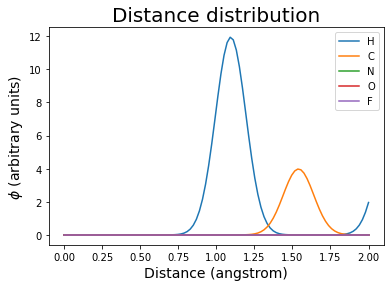

In [7]:
# Plot K2
x2 = mbtr.get_k2_axis() # this is the x axis of the histogram

# create some dictionaries to make atom Z <-- type index --> type name
imap = mbtr.index_to_atomic_number
smap = {}
for index, number in imap.items():
    smap[index] = ase.data.chemical_symbols[number]

# make the plots
for i in range(1, mbtr.n_elements): # avoid showing type 0 = X (the central atom)
    
    # this is the slice of the flattened MBTR tensor that contains the histogram
    # for X-type_i - X is the central atom of the LMBTR expansion
    slc = mbtr.get_location(('X',smap[i]))
    
    # this is the slice
    y2 = desc[0][slc]
    
    mpl.plot(x2, y2, label="{}".format(smap[i]))

mpl.ylabel("$\phi$ (arbitrary units)", size=14)
mpl.xlabel("Distance (angstrom)", size=14)
mpl.title("Distance distribution", size=20)
mpl.legend()
mpl.show()

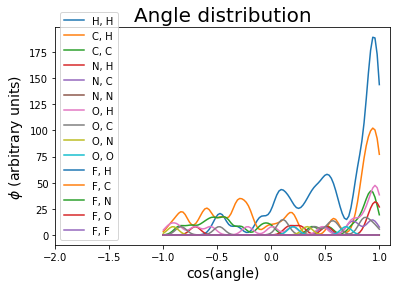

In [8]:
# Plot K3
x3 = mbtr.get_k3_axis()

for i in range(1, mbtr.n_elements):
    for j in range(1, mbtr.n_elements):
        if j <= i:
            slc = mbtr.get_location(('X',smap[i],smap[j]))
            mpl.plot(x3, desc[0][slc], label="{}, {}".format(smap[i], smap[j]))

mpl.xlim(left=-2)
mpl.ylabel("$\phi$ (arbitrary units)", size=14)
mpl.xlabel("cos(angle)", size=14)
mpl.title("Angle distribution", size=20)
mpl.legend(loc=3)
mpl.show()

## Remark

The LMBTR is a fingerprint of one atom. Thus, it can be used to:
1. Compare the similarity of two local chemical environments by comparing the LMBTR values.
2. Machine learn local properties, like charges, adsorption energies, etc.


## Exercise

Calculate the local MBTR for all other atoms.